# Chapter 6

## 6.1 Multicollinearity
## 6.2 Post-treatment Bias
## 6.3 Collider Bias
## 6.4 Confronting Confounding

## Intro
+ BERKSON'S PARADOX / SELECTION-DISTORTION EFFECT
+ Example below. Study proposals go to a committee, who rank on newsworthiness and trustworthiness. Each study gets an equally weighted rating assigned to newsw. and trustw., and tallies up the scores. Studies with highest scores are selected to go forward
+ Later someone does an analysis of studies and finds that newsworthiness and trustworthiness are negatively correlated
+ In the initial proposals, there was no correlation, but after selection there was.
+ This can happen with a multiple linear regression if we just keep adding variables. It iduces statistical selection inside the model - COLLIDER BIAS
![alt text](images/6/newsworthiness-trustworthiness.png "Title")

+ lecture 5 Link
    + https://www.youtube.com/watch?v=UpP-_mBvECI
    + Collider section at 40:34


In [60]:
library(rethinking)
library(dagitty)

# 6.1 Multicollinearity
+ Why not add all varaibles to multiple linear regression? Because Multicollinearity
+ Multicollinearity means strong association between variables. 
+ Important problem is association conditional on other variables in the model.
+ Posterior distribution will suggest none of variables are reliably associated with the outcome, even if all are associated with the outcome.
+ BUT, the model will work fine for prediction!!!
+ You will not be able to understand the model

## 6.1.1 Multicollinear legs
+ Predict height from leg length. Use left and right leg length - (very slightly different)

In [91]:
set.seed(909)
N <- 100 # N people
height <-rnorm(N, 10, 2) # Simulate height of N people, mean 10, stdev 2
leg_prop <- runif(N, 0.4, 0.5) # Simulate leg length as 0.4 to 0.5 proportion of height
left_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
right_leg <- (leg_prop * height) + rnorm(N, 0, 0.02) # sim l leg with error
d <- data.frame(height, left_leg, right_leg)
str(d)

'data.frame':	100 obs. of  3 variables:
 $ height   : num  5.93 6.51 9.35 9.23 10.36 ...
 $ left_leg : num  2.68 2.68 3.93 3.96 4.43 ...
 $ right_leg: num  2.71 2.68 3.98 3.99 4.42 ...


In [92]:
m6.1 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*left_leg + br*right_leg,
        a ~ dnorm(0, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ), data=d)
precis(m6.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9811156,0.2839607,0.5272915,1.4349396
bl,0.2138054,2.5270797,-3.8249560,4.2525669
br,1.7817631,2.5312933,-2.2637325,5.8272587
sigma,0.6171141,0.0434363,0.5476945,0.6865337


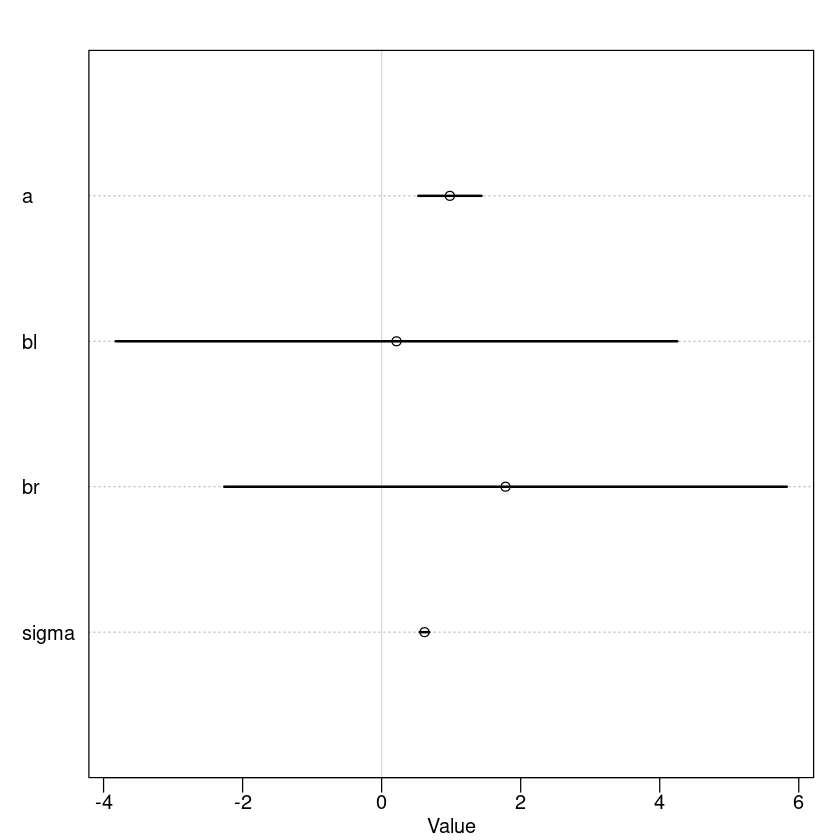

In [93]:
plot(precis(m6.1))

+ `Those posterior means and standard deviations look crazy` - I need a bit more help than that!
+ I guess the standard deviations for bl and br are higher than the mean. Not sure what else to look for here?
+ `What is the value of knowing each predictor, after already knowing all of the other predictors?` - so what is the value of knowing say the right leg length after knowing the right leg length
+ Plot the posterior distributions of bl and br against each other. These are very very strongly correlated. When bl is small, br must be big. 

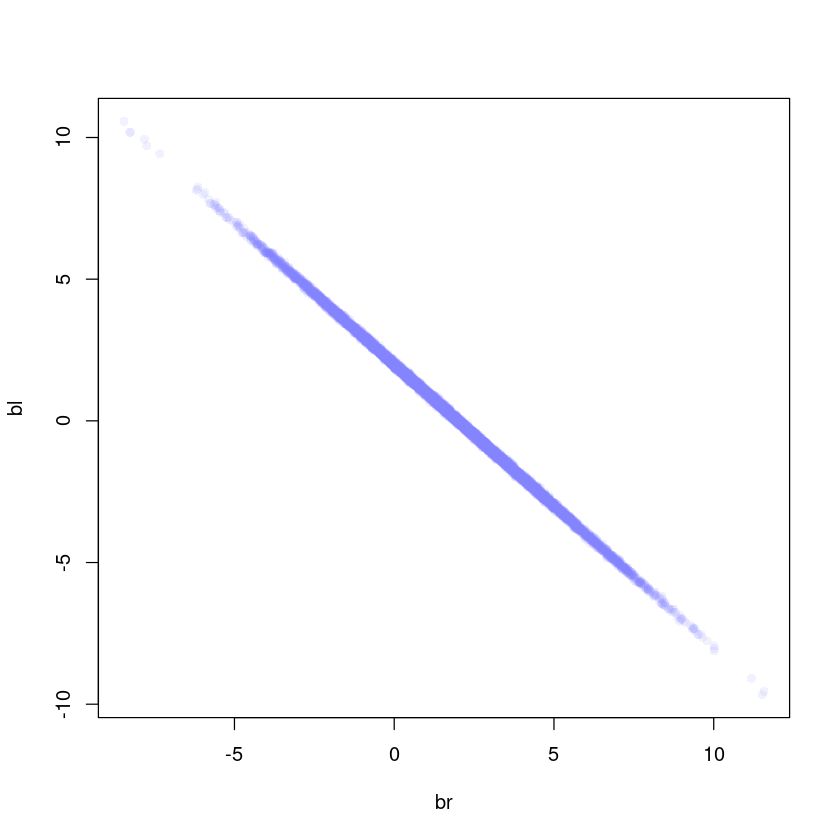

In [94]:
post <- extract.samples(m6.1)
plot( bl ~ br , post , col=col.alpha(rangi2,0.1) , pch=16 )

+ The model is like this:
    + $y_i \sim Normal(\mu_i, \sigma)$
    + $\mu_i = \alpha + \beta_1x_i + \beta_2x_i$
    + where:
        + x is a single predictor
+ But that is the like this:    
    + $\mu_i = \alpha + (\beta_1 + \beta_2)x_i$
+ The posterior is giving us back the sum of $\beta_1$ and $\beta_2$

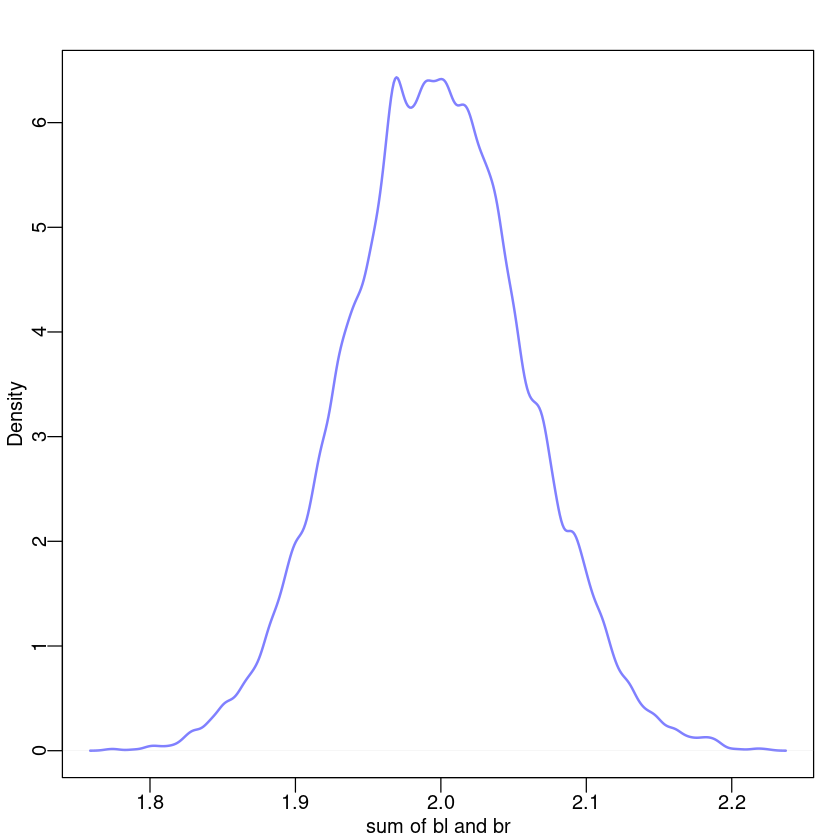

In [95]:
sum_blbr <- post$bl + post$br
dens(sum_blbr, col=rangi2, lwd=2, xlab="sum of bl and br")

+ Now fit regression using a single leg length

In [96]:
m6.2 <- quap(
 alist(
  height ~ dnorm(mu, sigma),
  mu <- a + bl*left_leg,
  a ~ dnorm(10, 100),
  bl ~ dnorm(2, 10),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9979326,0.28364620,0.5446112,1.451254
bl,1.9920676,0.06115704,1.8943269,2.089808
sigma,0.6186038,0.04353998,0.5490185,0.688189


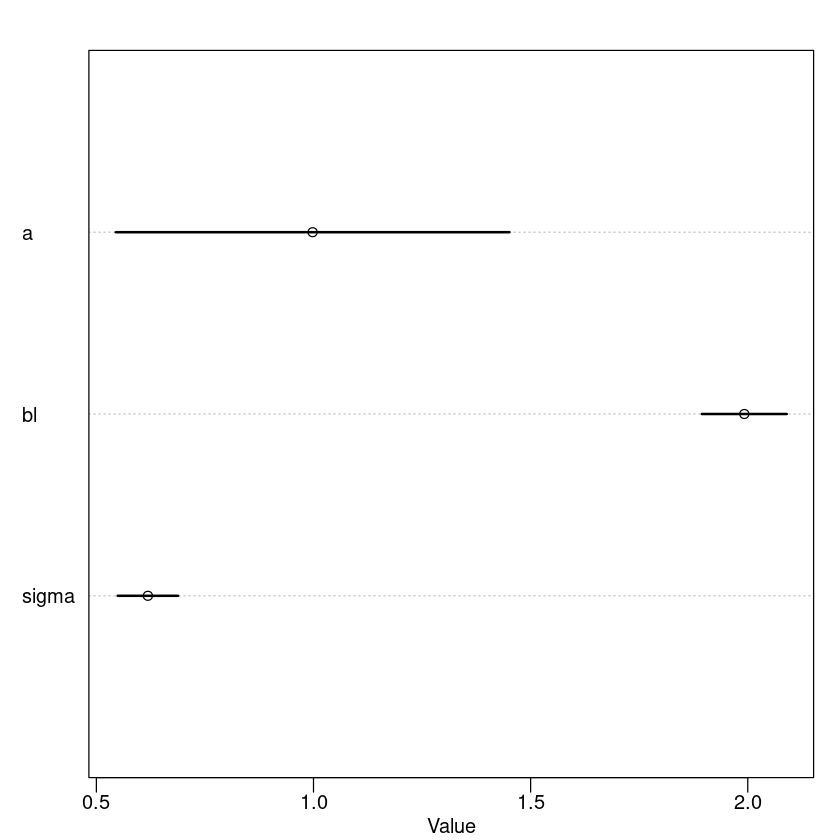

In [97]:
plot(precis(m6.2))

+ takeaway
+ When 2 predictors are highly correlated (conditional on other variables in the model) - What does this mean? - including both will be confusing.
+ Strictly the model output will be correct, but interpretability will be lacking
+ The risk is that we include highly correlated variables in the model, and the model tells us neither is important.

### 6.1.2 Multicollinear milk
+ Predict calories in milk from percentage lactose, and % fat

In [99]:
library(rethinking)
data(milk)
d <- milk
d$K <- standardize(d$kcal.per.g)
d$F <- standardize(d$perc.fat)
d$L <- standardize(d$perc.lactose)

[1] "K is target"


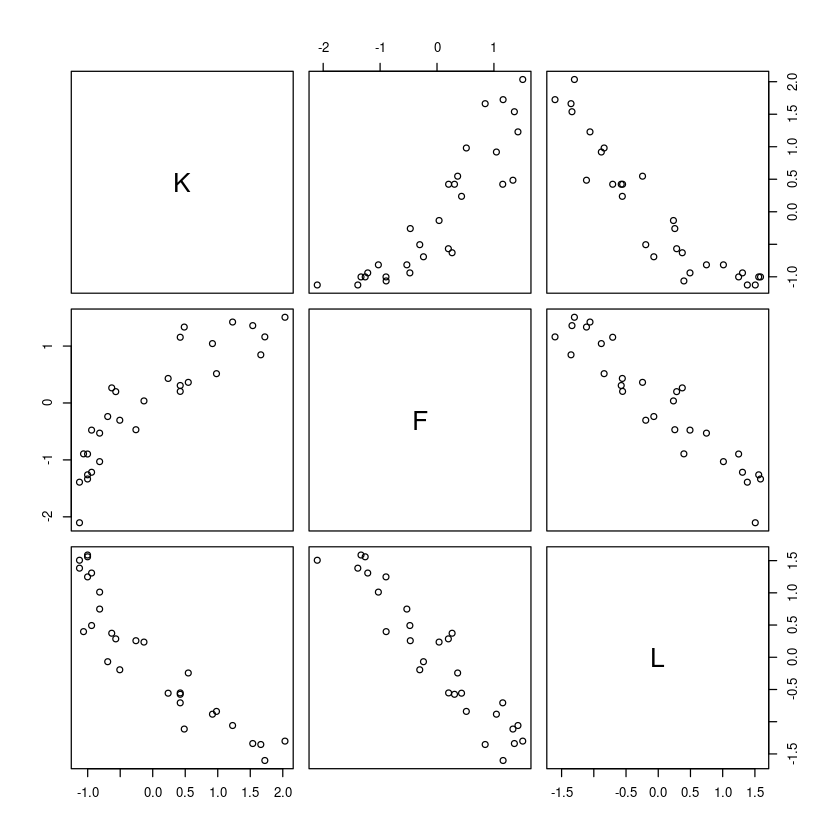

In [106]:
# pairs(d[, d$K, d$F, d$L])
pairs(d[, c("K", "F", "L")])
print('K is target')

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.092037e-08,0.07725207,-0.1234637,0.1234637
bF,8.618969e-01,0.08426103,0.7272315,0.9965623
sigma,4.510188e-01,0.05870784,0.3571923,0.5448453


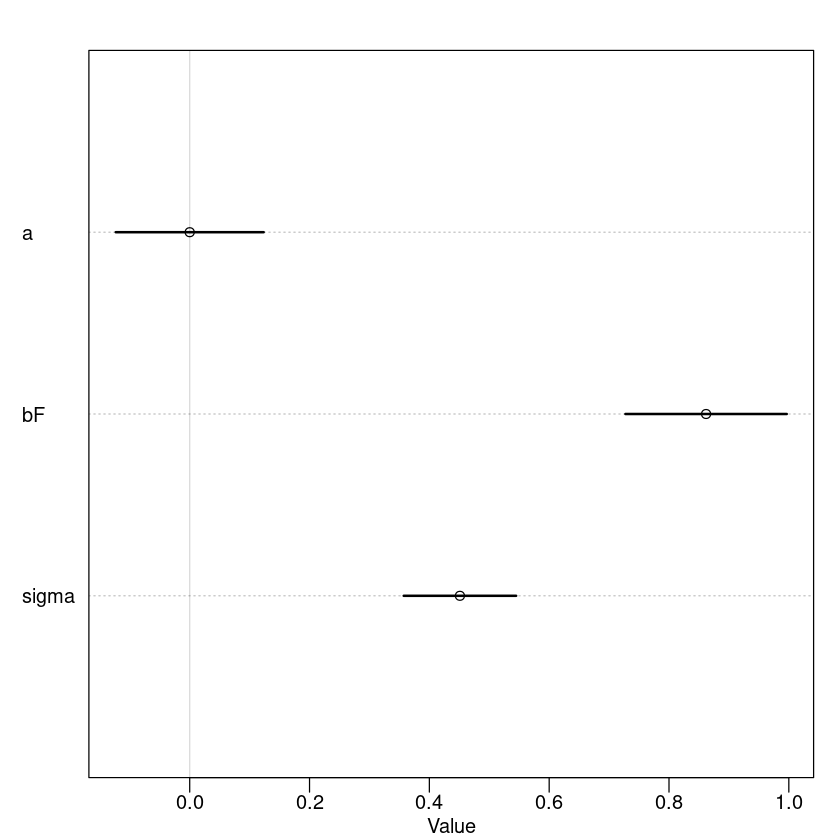

In [108]:
# kcal.per.g regressed on perc.fat
m6.3 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.3)
plot(precis(m6.3))

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.654920e-07,0.06661634,-0.1064656,0.1064659
bL,-9.024533e-01,0.07132852,-1.0164500,-0.7884565
sigma,3.804653e-01,0.04958261,0.3012227,0.4597079


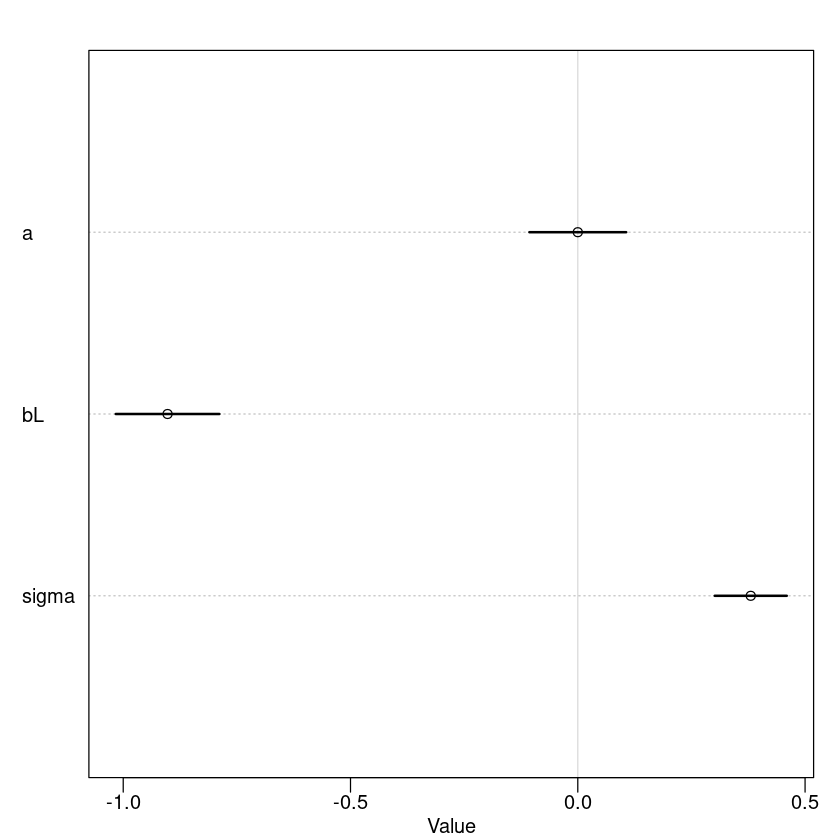

In [109]:
# kcal.per.g regressed on perc.lactose
m6.4 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bL*L,
  a ~ dnorm(0, 0.2),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d )
precis(m6.4)
plot(precis(m6.4))

In [ ]:
+ Using both variables in the same model

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.662863e-06,0.06603574,-0.10553620,0.1055395
bF,2.434976e-01,0.18357855,-0.04989642,0.5368916
bL,-6.780822e-01,0.18377662,-0.97179275,-0.3843717
sigma,3.767416e-01,0.04918386,0.29813626,0.4553469


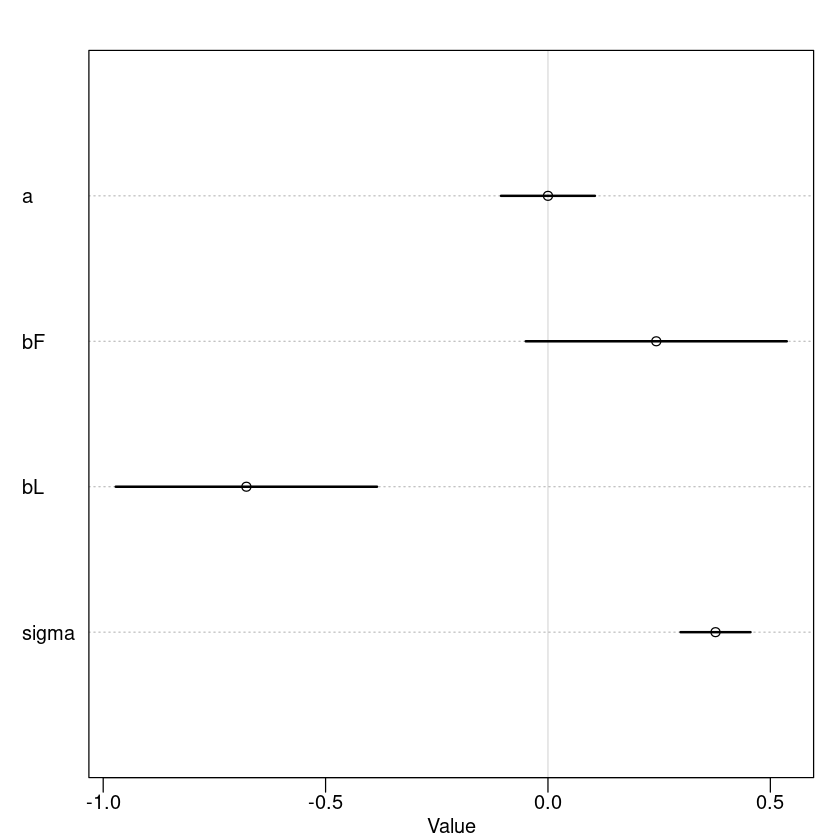

In [110]:
m6.5 <- quap(
 alist(
  K ~ dnorm(mu, sigma),
  mu <- a + bF*F + bL*L,
  a ~ dnorm(0, 0.2),
  bF ~ dnorm(0, 0.5),
  bL ~ dnorm(0, 0.5),
  sigma ~ dexp(1)
 ) , data=d)

precis(m6.5)
plot(precis(m6.5))

+ Easier to see on the plot than author's description
+ Standard deviations of $\beta$s are much bigger

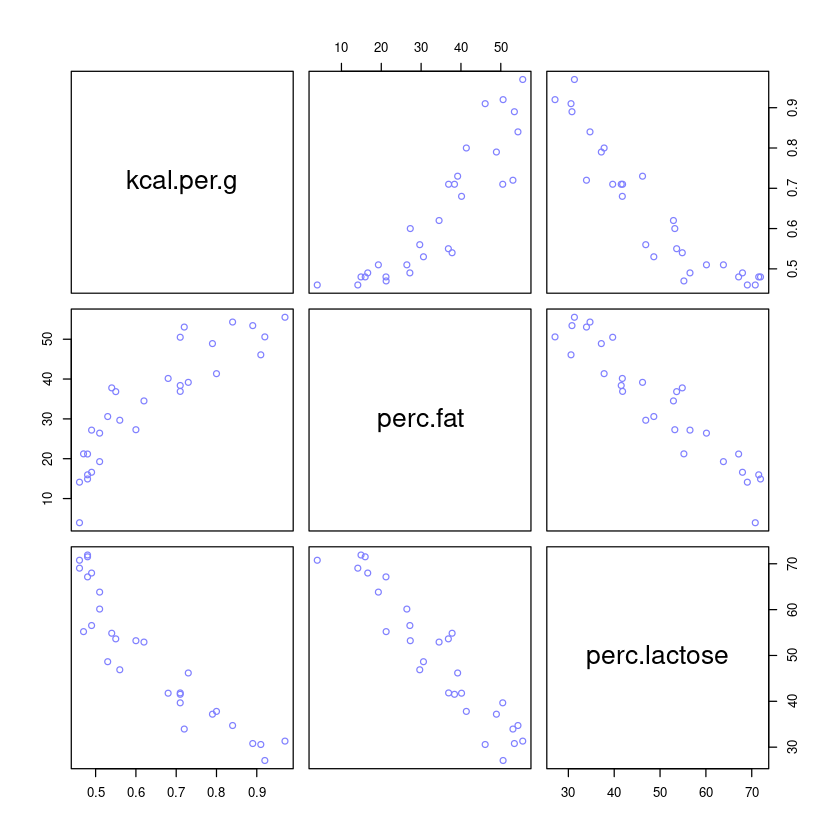

In [111]:
pairs( ~ kcal.per.g + perc.fat + perc.lactose , data=d , col=rangi2 )

+ takeaway
+ `Either helps in predicting kcal.per.g, but neither helps as much once you already know the other.`
+ WRONG APPROACH
    + inspect pairwise correlations prior to fitting a model and drop one side of highly correlated predictors
    + This is wrong because correlations do not matter - Conditional association matters
+ With the milk, there is likely a tradeoff between fat and lactose (lactose = sugar)
+ The causal model looks like:

![alt text](images/6/milk-causal-model.png "Title")

+ Tradeoff is D - Density - This is unobserved
+ If we could measure D, that would be a better causal model
+ NON-IDENTIFIABILITY - Parameter is not identified - the model structure means the variable's parameter cannot be estimated
+ If there is not much information in the data, then the posterior distribution will be similar to the prior. Can use this to gauge how much the model is helping us.
+ Simulation below (As per usual there is no title and the axes are labeled in the most minimal way possible)
+ Impreciseness of predictor (standard deviation) gets bigger as association between variables get bigger

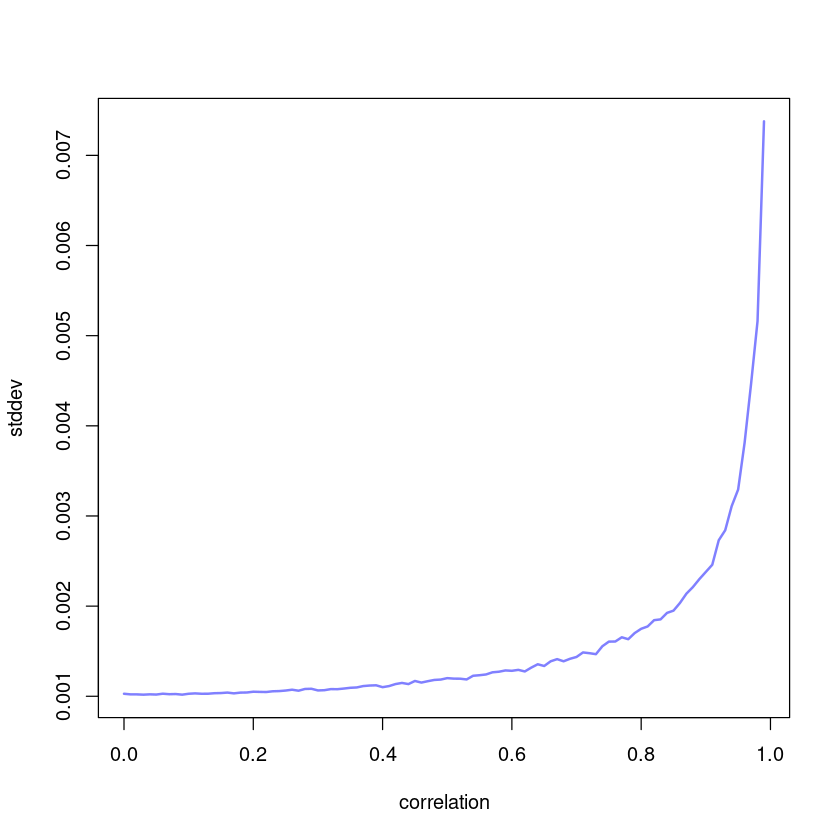

In [113]:
data(milk)
d <- milk
sim.coll <- function( r=0.9 ) {
 d$x <- rnorm( nrow(d) , mean=r*d$perc.fat ,
  sd=sqrt( (1-r^2)*var(d$perc.fat) ) )
 m <- lm( kcal.per.g ~ perc.fat + x , data=d )
 sqrt( diag( vcov(m) ) )[2] # stddev of parameter
}
rep.sim.coll <- function( r=0.9 , n=100 ) {
 stddev <- replicate( n , sim.coll(r) )
 mean(stddev)
}
r.seq <- seq(from=0,to=0.99,by=0.01)
stddev <- sapply( r.seq , function(z) rep.sim.coll(r=z,n=100) )
plot( stddev ~ r.seq , type="l" , col=rangi2, lwd=2 , xlab="correlation")

# 6.2 Post treament Bias